78% Accuracy Model

In [2]:
import os
import sys
import re
import pandas as pd
import time
import numpy as np
import pickle
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import keras
import tensorflow as tf
import keras.utils


from keras.models import Sequential, Model
from keras.layers import Input, Embedding, Reshape, LSTM, Bidirectional
from keras.layers import TimeDistributed, Activation, SimpleRNN, GRU
from keras.layers import Flatten, Dense, Dropout, Lambda
from keras.layers import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
from keras.metrics import categorical_crossentropy, categorical_accuracy
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.layers import *
from tensorflow.keras.preprocessing import image, sequence
from tensorflow.keras.preprocessing.text import Tokenizer
import operator
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
%matplotlib inline

In [4]:
names=['category','title','desc']
df = pd.read_csv('dmoz.csv',delimiter=',',encoding='latin-1',names=names, na_filter=False)
#df.fillna(0)
#df = df[100000:2196860]
#df.drop(df.index[200000:315000], inplace=True)
#df.drop(df.index[810000:925000], inplace=True)
df=df.iloc[1:]
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'dmoz.csv'

Text(0, 0.5, 'Total Number Of Individual Category')

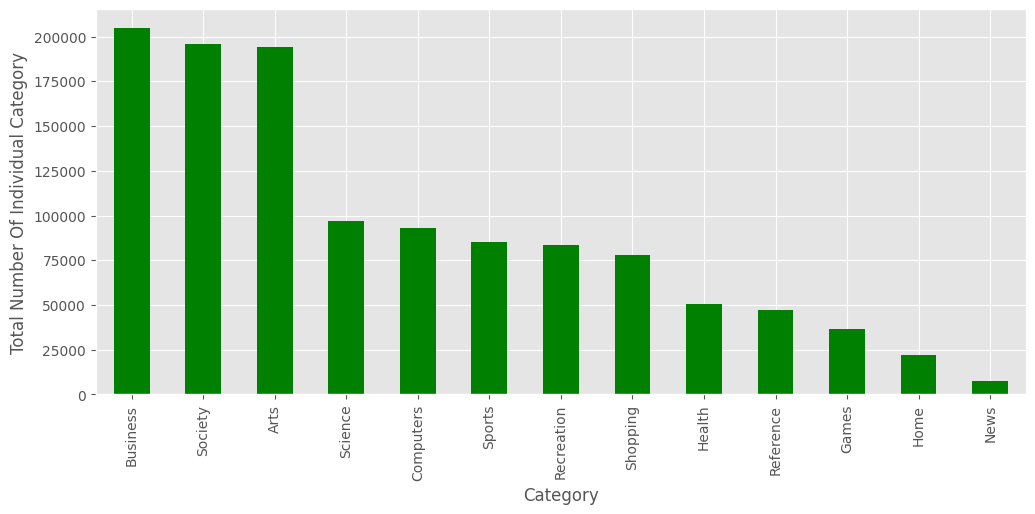

In [11]:
df.category.value_counts().plot(figsize=(12,5),kind='bar',color='green')
plt.xlabel('Category')
plt.ylabel('Total Number Of Individual Category')

In [12]:
df.desc = df.title + ' ' + df.desc
df = df.drop(['title'], axis=1)
df.desc = df.desc.str.lower()

1008 10 130.81018872752543


C:\Users\tmachine\AppData\Local\Temp\ipykernel_17704\3471613222.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lens);


Text(0.5, 1.0, 'Description length distribution')

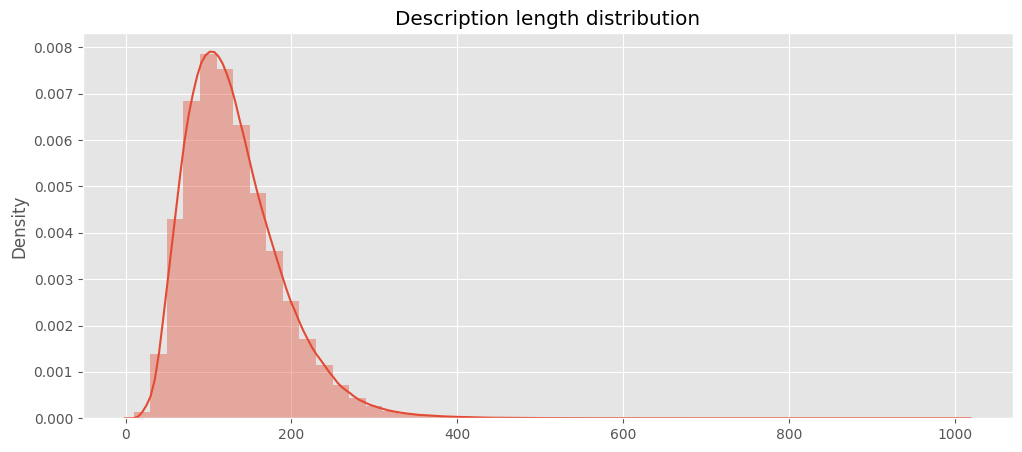

In [13]:
lens = [len(x) for x in df.desc]
plt.figure(figsize=(12, 5));
print (max(lens), min(lens), np.mean(lens))
sns.distplot(lens);
plt.title('Description length distribution')

In [14]:
import re
vocab_size = 5100
seq_len = 250
words = [re.findall('[\w\d]+', x) for x in df.desc]

In [15]:
all_words = []
for x in words:
    all_words += x

In [16]:
word_to_id = Counter(all_words).most_common(vocab_size)

In [17]:
word_to_id[:10]


[('and', 1542578),
 ('of', 697786),
 ('the', 621247),
 ('in', 361121),
 ('a', 302008),
 ('for', 283425),
 ('to', 226417),
 ('information', 222877),
 ('on', 157232),
 ('s', 133901)]

In [18]:
word_to_id[-10:]


[('encryption', 455),
 ('forecasts', 455),
 ('invitations', 454),
 ('prepare', 454),
 ('carter', 454),
 ('toolkit', 454),
 ('comment', 453),
 ('evening', 453),
 ('exterior', 453),
 ('futures', 453)]

In [19]:
word_to_id = {x[0]:i for i, x in enumerate(word_to_id)}


In [20]:
train = [np.array([word_to_id[y] if y in word_to_id else vocab_size-1 for y in x]) for x in words]


In [21]:
train = sequence.pad_sequences(train, maxlen=seq_len, value=0)
train = train.astype('float32')

In [22]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df.category)
y_data = le.transform(df.category)
X_data = df.desc.values

In [24]:
from keras.utils import to_categorical
y_data = to_categorical(y_data)
X_train, X_test, y_train, y_test = train_test_split(train, y_data, test_size=0.3, random_state=1000)

In [25]:
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=seq_len))
model.add(Dropout(0.1))
model.add(Conv1D(64,5,padding='valid',activation='relu'))
model.add(Dropout(0.2))
model.add(Conv1D(128,5,padding='valid',activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(64, activation='relu' ))
model.add(Dropout(0.2))
model.add(Dense(13, activation='softmax'))
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 50)           255000    
                                                                 
 dropout (Dropout)           (None, 250, 50)           0         
                                                                 
 conv1d (Conv1D)             (None, 246, 64)           16064     
                                                                 
 dropout_1 (Dropout)         (None, 246, 64)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 242, 128)          41088     
                                                                 
 dropout_2 (Dropout)         (None, 242, 128)          0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 121, 128)         

In [26]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [27]:
model.optimizer.lr = 1e-3

In [28]:
model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=15,batch_size=64)

Epoch 1/15


13080/13080 [==============================] - 717s 55ms/step - loss: 0.9591 - accuracy: 0.7097 - val_loss: 0.7641 - val_accuracy: 0.7639
Epoch 2/15
13080/13080 [==============================] - 397s 30ms/step - loss: 0.7782 - accuracy: 0.7608 - val_loss: 0.7125 - val_accuracy: 0.7764
Epoch 3/15
13080/13080 [==============================] - 400s 31ms/step - loss: 0.7386 - accuracy: 0.7705 - val_loss: 0.6944 - val_accuracy: 0.7812
Epoch 4/15
13080/13080 [==============================] - 819s 63ms/step - loss: 0.7162 - accuracy: 0.7751 - val_loss: 0.6823 - val_accuracy: 0.7840
Epoch 5/15
13080/13080 [==============================] - 672s 51ms/step - loss: 0.7031 - accuracy: 0.7781 - val_loss: 0.6780 - val_accuracy: 0.7843
Epoch 6/15
13080/13080 [==============================] - 711s 54ms/step - loss: 0.6934 - accuracy: 0.7808 - val_loss: 0.6711 - val_accuracy: 0.7865
Epoch 7/15
13080/13080 [==============================] - 743s 57ms/step - loss: 0.6867 - accuracy: 0.78

In [29]:
from sklearn import metrics
preds = [np.argmax(x) for x in model.predict(X_test)]
y_test_argmax = [np.argmax(x) for x in y_test]
print(metrics.classification_report(preds, y_test_argmax, target_names=le.classes_))

11212/11212 [==============================] - 39s 4ms/step
              precision    recall  f1-score   support

        Arts       0.87      0.80      0.83     62626
    Business       0.86      0.79      0.82     67116
   Computers       0.82      0.72      0.77     31575
       Games       0.69      0.86      0.76      8785
      Health       0.80      0.77      0.79     15673
        Home       0.66      0.75      0.70      5781
        News       0.49      0.77      0.60      1404
  Recreation       0.76      0.73      0.75     26295
   Reference       0.62      0.73      0.67     12118
     Science       0.68      0.73      0.70     26949
    Shopping       0.66      0.78      0.71     19739
     Society       0.79      0.82      0.80     56835
      Sports       0.86      0.92      0.89     23860

    accuracy                           0.79    358756
   macro avg       0.73      0.78      0.75    358756
weighted avg       0.79      0.79      0.79    358756



<Axes: >

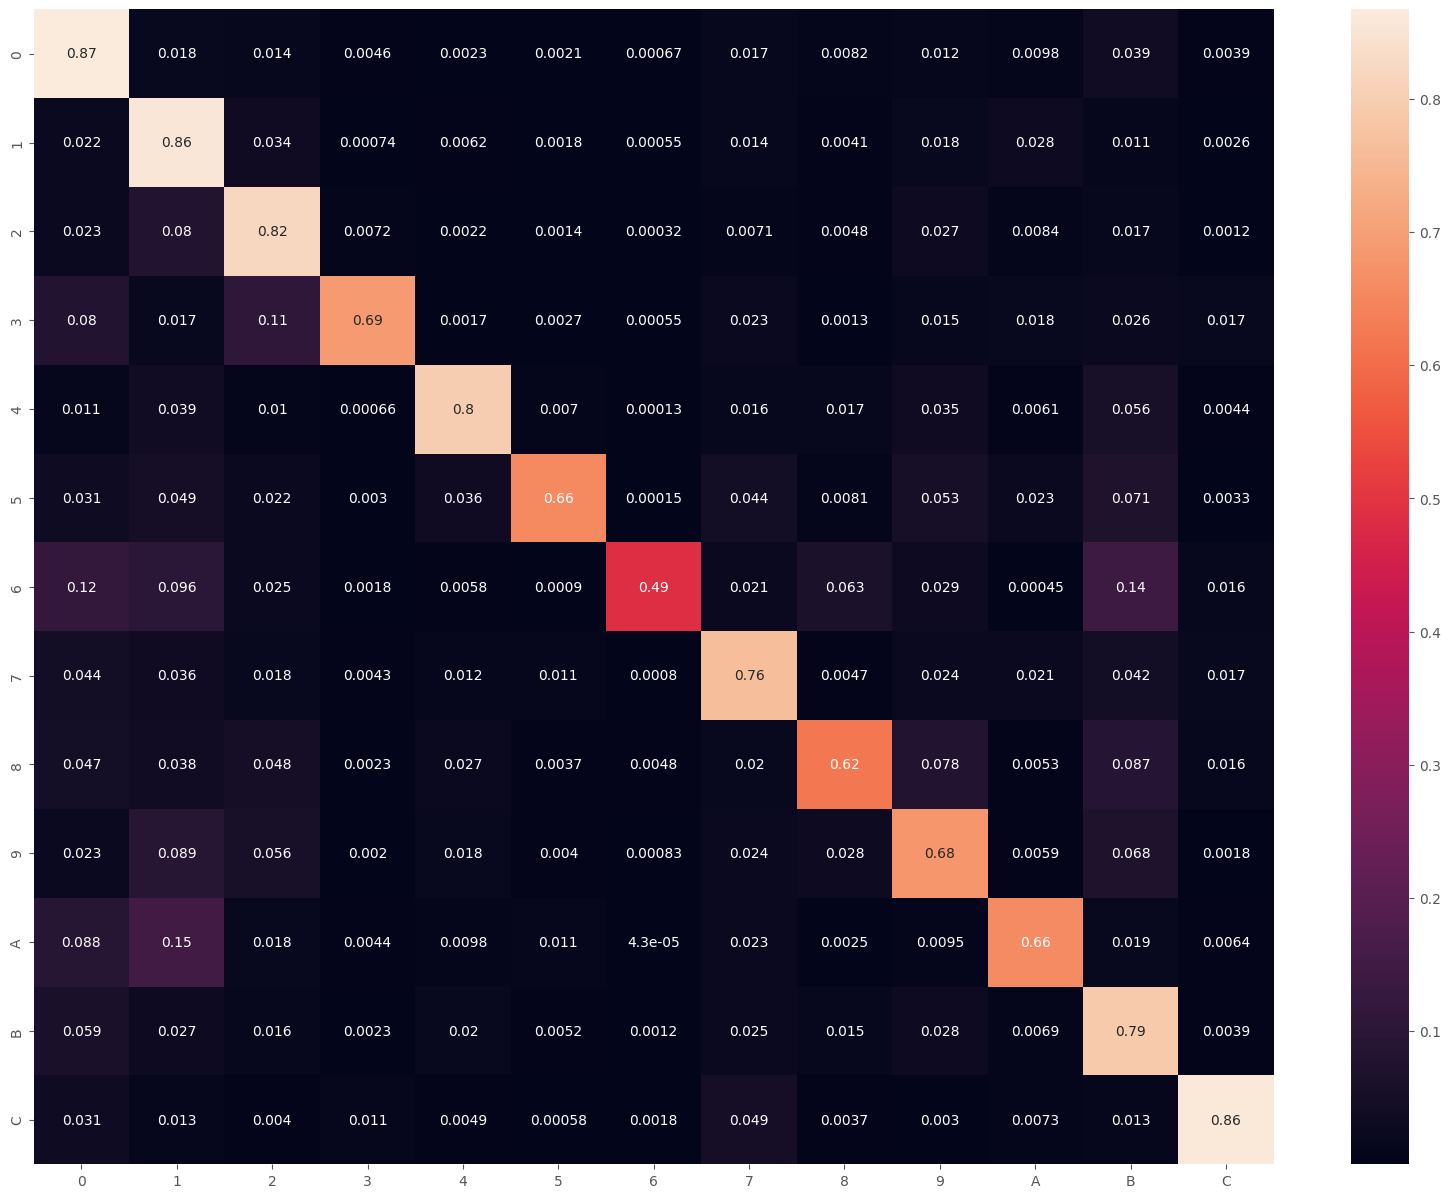

In [30]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
array = confusion_matrix(y_test_argmax, preds)
cm=np.array(array)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm, index = [i for i in "0123456789ABC"],
                  columns = [i for i in "0123456789ABC"])
plt.figure(figsize = (20,15))
sn.heatmap(df_cm, annot=True)

In [31]:
model.save('Deep_Learning_url_classification')

INFO:tensorflow:Assets written to: Deep_Learning_url_classification\assets


INFO:tensorflow:Assets written to: Deep_Learning_url_classification\assets


In [32]:
model.save('Deep_Learning_url_classification.h5')

c:\Users\tmachine\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
